<a href="https://colab.research.google.com/github/Mychail/Data_Science/blob/main/ML_Rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rainfall ML Project**

## **Load Dataset**

In [1]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (2).json


In [2]:
!kaggle competitions download -c playground-series-s5e3

playground-series-s5e3.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -qq playground-series-s5e3.zip

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
ls

'kaggle (1).json'   kaggle.json                  sample_data/            test.csv
'kaggle (2).json'   playground-series-s5e3.zip   sample_submission.csv   train.csv


## **Import Dependables**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
df = pd.read_csv('train.csv')

df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


## **Data Exploration**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [8]:
df.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [9]:
features = ['pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed']

df[features].head()
X = df[features]
y = df['rainfall']

In [10]:
X_corr = X.corr()

<Axes: >

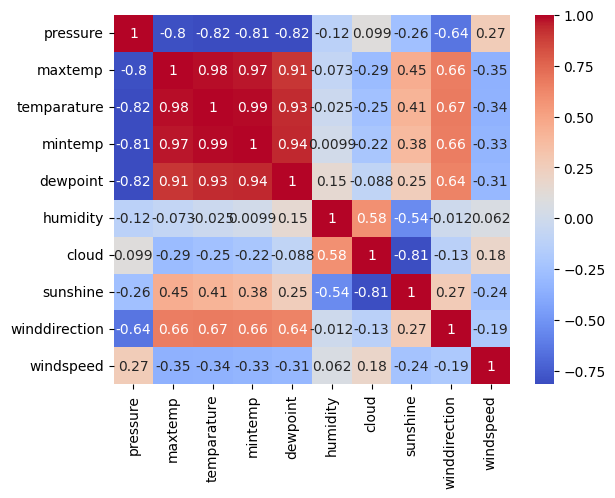

In [11]:
sns.heatmap(X_corr, annot=True, cmap='coolwarm')


## **Feature Engineering**

### **Using VIF to check Feature to Drop**

In [12]:
X = df[['maxtemp', 'temparature', 'mintemp', 'dewpoint']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,feature,VIF
0,maxtemp,689.994007
1,temparature,1769.874674
2,mintemp,901.330432
3,dewpoint,139.178797


In [13]:
df = df.drop(columns=["maxtemp", "mintemp", "temparature"])

In [14]:
features = ['pressure','dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed']
df[features].head()
X = df[features]
X.corr()

,pressure,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
pressure,1.000000,-0.817008,-0.119949,0.098600,-0.257163,-0.643293,0.266012
dewpoint,-0.817008,1.000000,0.153390,-0.088446,0.249676,0.643073,-0.312179
humidity,-0.119949,0.153390,1.000000,0.584854,-0.541592,-0.012430,0.062285
cloud,0.098600,-0.088446,0.584854,1.000000,-0.805128,-0.127087,0.184698
sunshine,-0.257163,0.249676,-0.541592,-0.805128,1.000000,0.272235,-0.241752
winddirection,-0.643293,0.643073,-0.012430,-0.127087,0.272235,1.000000,-0.192417
windspeed,0.266012,-0.312179,0.062285,0.184698,-0.241752,-0.192417,1.000000


<Axes: >

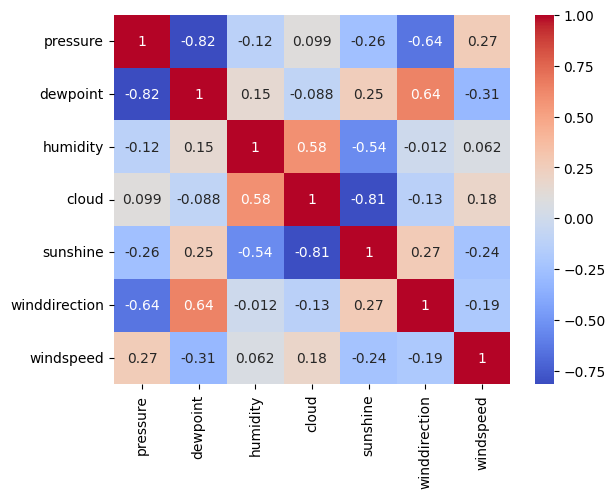

In [15]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')

In [16]:
y.value_counts(normalize=True)

,proportion
rainfall,
1,0.753425
0,0.246575


## **Model Building**

In [17]:
pp = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

In [18]:
pp.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## **Evaluate Model**

In [19]:
lr_train_pred = pp.predict(X)

In [20]:
roc_auc_score(y, lr_train_pred)

0.7903703703703704

## **Test Data Loading**

In [39]:
df = pd.read_csv("test.csv")

In [40]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB


In [44]:
df[df["winddirection"].isnull()]

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2


In [45]:
df["winddirection"] = df["winddirection"].fillna(df["winddirection"].mode()[0])

In [46]:
df["winddirection"].value_counts()

,count
winddirection,
70.0,97
220.0,85
40.0,85
20.0,81
50.0,61
60.0,52
230.0,52
80.0,51
30.0,29


In [47]:
X_test = df[['pressure', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed']]


In [48]:
lr_test_pred = pp.predict_proba(X_test)[:, 1]

In [49]:
type(lr_test_pred)

numpy.ndarray

In [50]:
df["id"]

,id
0,2190
1,2191
2,2192
3,2193
4,2194
...,...
725,2915
726,2916
727,2917
728,2918


In [51]:
df["rainfall"] = lr_test_pred.round(2)

In [52]:
df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,0.98
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,0.98
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,0.91
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,0.13
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,0.04


In [54]:
df[["id", "rainfall"]].to_csv("submission.csv", index=False)